Image Reconstruction

Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (X, Y) to the pixel colors (R, G, B). Here, (X, Y) represents the coordinates of the pixels, and (R, G, B) represents the color values at those coordinates.

1. **Load Image**: Select any image of your choice.
2. **Random Fourier Features (RFF)**: Implement RFF to map pixel coordinates to color values.
3. **Linear Regression**: Use linear regression to learn the mapping.
4. **Display Results**: Show both the original and reconstructed images.
5. **Metrics**: Calculate the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.

**Key Variables**:
- X, Y: Pixel coordinates.
- R, G, B: Pixel color values.


### Latexify

In [1]:
'''
Code snippet copied from [https://github.com/nipunbatra/ml-teaching/blob/e2cd59d3e3358473ebfcf70e71d70361bb4501b4/latexify.py#L9] by Nipun Batra
Date: 14 th August , 2024

Changes :
'text.latex.preamble': '\\usepackage{gensymb}',
'text.usetex': False,

'''


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib

from math import sqrt
SPINE_COLOR = 'gray'

def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': '\\usepackage{gensymb}',
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': False,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax



## Importing necessary libraries

In [2]:
import torch
print(torch.__version__)

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops

    from einops import rearrange

2.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 668.7 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print(torch.cuda.get_device_name(0))
print("CUDA available:", torch.cuda.is_available())

Tesla T4
CUDA available: True


## Importing image

In [4]:
import os

# Define the directory path
directory_path = '../assets/images/'

# Check if the directory exists, and create it if it does not
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Check if the file exists
if os.path.exists(os.path.join(directory_path, 'iitgn.jpeg')):
    print('iitgn.jpeg exists')
else:
    # Download the file if it does not exist
#     !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O ../assets/images/dog.jpg
#     !wget https://campus.iitgn.ac.in/gallery/academic_area/data1/images/central_samvad_in_the_academic_spine.jpg -O ../assets/images/iitgn.jpg
    !wget https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg -O ../assets/images/iitgn.jpeg


--2024-09-14 22:36:48--  https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg
Resolving news.iitgn.ac.in (news.iitgn.ac.in)... 192.185.129.4
Connecting to news.iitgn.ac.in (news.iitgn.ac.in)|192.185.129.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238762 (233K) [image/jpeg]
Saving to: '../assets/images/iitgn.jpeg'

../assets/images/ii 100%[===================>] 233.17K  --.-KB/s    in 0.1s    

2024-09-14 22:36:49 (2.03 MB/s) - '../assets/images/iitgn.jpeg' saved [238762/238762]



In [5]:
# !wget https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg -O ../assets/images/iitgn.jpeg

# Read in a image from torchvision
img = torchvision.io.read_image("../assets/images/iitgn.jpeg")
print(img.shape)

torch.Size([3, 600, 900])


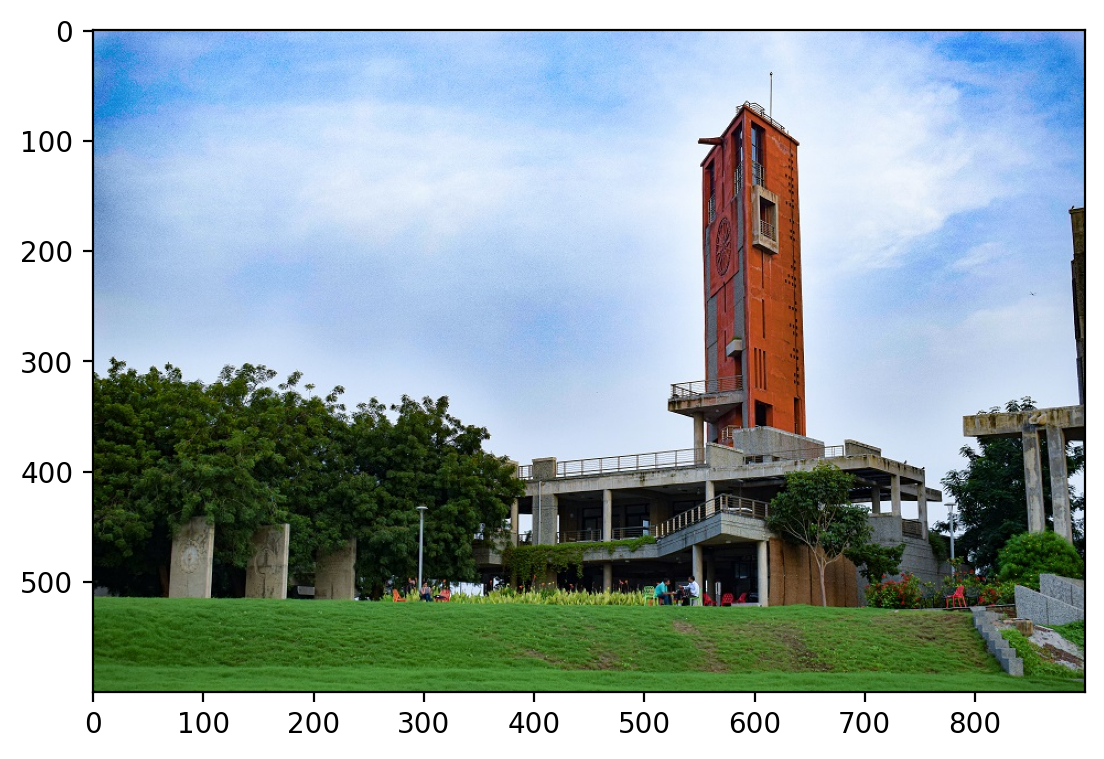

In [7]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
# plt.axis('off')
plt.show()

In [ ]:
# # Read in a image from torchvision
# iitgn_img = torchvision.io.read_image("../assets/images/iitgn.jpg")
# print(iitgn_img.shape)
# plt.imshow(rearrange(iitgn_img, 'c h w -> h w c').numpy())


In [8]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [9]:

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)


(3, 600, 900)


In [10]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.5412, 0.5333, 0.4863,  ..., 0.5451, 0.5608, 0.5412],
         [0.5059, 0.5373, 0.5059,  ..., 0.5647, 0.5451, 0.5451],
         [0.5412, 0.5333, 0.5098,  ..., 0.5647, 0.5216, 0.5373],
         ...,
         [0.2627, 0.2941, 0.2549,  ..., 0.2314, 0.2157, 0.1843],
         [0.1647, 0.1647, 0.1882,  ..., 0.2314, 0.2196, 0.2078],
         [0.2039, 0.2275, 0.2588,  ..., 0.2157, 0.2039, 0.2157]],

        [[0.6902, 0.6902, 0.6667,  ..., 0.6667, 0.6824, 0.6627],
         [0.6549, 0.6941, 0.6667,  ..., 0.6863, 0.6667, 0.6667],
         [0.6784, 0.6706, 0.6471,  ..., 0.6863, 0.6431, 0.6588],
         ...,
         [0.4667, 0.4980, 0.4588,  ..., 0.4157, 0.4000, 0.3686],
         [0.3647, 0.3647, 0.3882,  ..., 0.4157, 0.4039, 0.3922],
         [0.4039, 0.4275, 0.4588,  ..., 0.4000, 0.3882, 0.4000]],

        [[0.9333, 0.9294, 0.9020,  ..., 0.9294, 0.9451, 0.9255],
         [0.8980, 0.9333, 0.9098,  ..., 0.9490, 0.9294, 0.9294],
         [0.9294, 0.9216, 0.9059,  ..., 0.9412, 0.8980, 0.

## Crop the image

In [11]:
# crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
# crop.shape


center_crop = torchvision.transforms.CenterCrop(600)  # Crop to a 300x300 square
crop = center_crop(img_scaled.cpu())
print(crop.shape)


torch.Size([3, 600, 600])


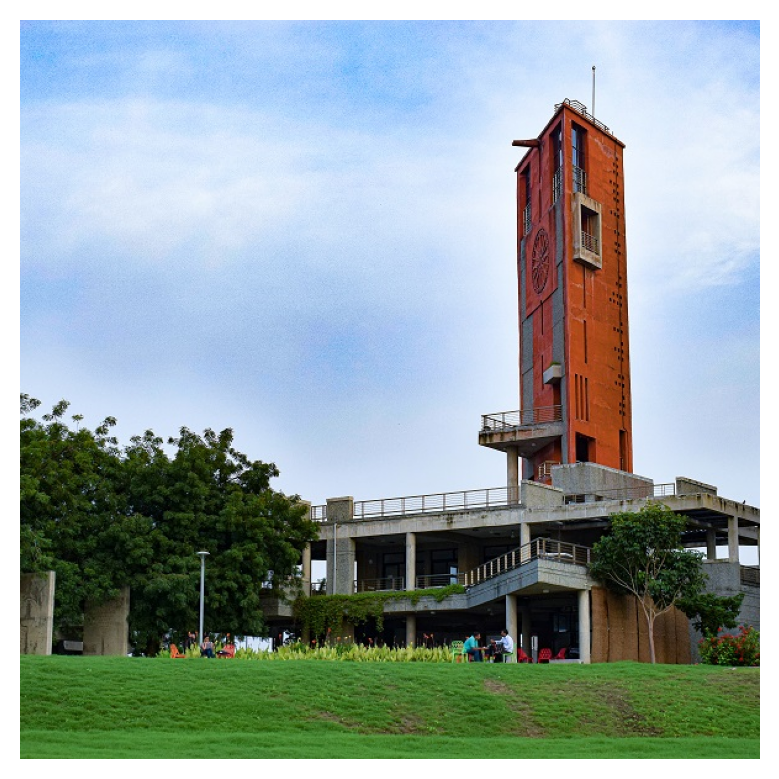

In [12]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
plt.axis('off')
plt.show()

In [13]:
crop = crop.to(device)

## Create a coordinate map

In [14]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    print("Number of channels:", num_channels, "\nHeight:", height, "\nWidth:", width)
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    print("X shape:", X.shape)
    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    print("Y shape:", Y.shape)

    return X, Y

In [15]:
dog_X, dog_Y = create_coordinate_map(crop)

print(dog_X) # (300*300, 2)- coordinates
print(dog_Y) # (300*300, 3)- RGB values

Number of channels: 3 
Height: 600 
Width: 600
X shape: torch.Size([360000, 2])
Y shape: torch.Size([360000, 3])
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [599., 597.],
        [599., 598.],
        [599., 599.]], device='cuda:0')
tensor([[0.5490, 0.6863, 0.9451],
        [0.6235, 0.7608, 1.0000],
        [0.5490, 0.6980, 0.9529],
        ...,
        [0.2549, 0.4941, 0.1882],
        [0.2627, 0.4902, 0.1882],
        [0.2235, 0.4510, 0.1490]], device='cuda:0')


In [16]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

### Functions to Calculate RMSE and PSNR

In [17]:
# Functions to calculate RMSE and PSNR
def calculate_rmse(original_image, reconstructed_image):
    """Calculate the RMSE between the original and reconstructed images."""
    mse = torch.mean((original_image - reconstructed_image) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def calculate_psnr(original_image, reconstructed_image, max_pixel_value=1.0):
    """Calculate the PSNR between the original and reconstructed images."""
    mse = torch.mean((original_image - reconstructed_image) ** 2)
    if mse == 0:  # MSE is zero means images are identical
        return float('inf')
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

### Setting up device

In [18]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Set the random seed for reproducibility
torch.manual_seed(42)

# Detect GPU and enable multi-GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")


Using 2 GPUs


### Defining Linear Model

In [19]:
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

## Reconstructing using Linear Model

In [ ]:
net = LinearModel(2, 3).to(device)
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

print(net)
print("-"*50)
print("Weights:", net.module.linear.weight if torch.cuda.device_count() > 1 else net.linear.weight)
print("Bias:", net.module.linear.bias if torch.cuda.device_count() > 1 else net.linear.bias)
print("-"*50)

# Training function without batches
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    losses = []
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scaler = GradScaler()  # Use mixed precision training for efficiency

    for epoch in range(1, epochs+1):
        optimizer.zero_grad()

        # Mixed precision training
        with autocast():
            outputs = net(X)
            loss = criterion(outputs, Y)

        # Scale loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Track loss per epoch
        losses.append(loss.item())

        if verbose and epoch % 200 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

        # Clear unused memory after each epoch
        torch.cuda.empty_cache()

    return losses


print("Start Training")
train_loss = train(net, lr=0.01, X=dog_X_scaled, Y=dog_Y, epochs=1000)

print("-"*50)

# Plot training loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Assuming original_images and reconstructed_clipped_images are available
# Replace these placeholders with actual tensors
original_image = torch.tensor(original_images[-1]).to(device)
reconstructed_clipped_image = torch.tensor(reconstructed_clipped_images[-1]).to(device)



# Calculate RMSE and PSNR (implement these functions if not already available)
rmse_value = calculate_rmse(original_image, reconstructed_clipped_image)
print(f"RMSE: {rmse_value}")

psnr_value = calculate_psnr(original_image, reconstructed_clipped_image)
print(f"PSNR: {psnr_value}")

# Plot function for reconstructed and original images
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    """
    net.eval()
    with torch.no_grad():
        outputs = net(X).cpu().numpy()

    num_channels, height, width = original_img.shape
    outputs = outputs.reshape(height, width, num_channels)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

    ax0.imshow(outputs)
    ax0.set_title("Reconstructed Image")
    ax0.axis("off")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    ax1.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

# Assuming crop and dog_X_scaled are available
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image")


DataParallel(
  (module): LinearModel(
    (linear): Linear(in_features=2, out_features=3, bias=True)
  )
)
--------------------------------------------------
Weights: Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427]], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([-0.3443,  0.4153,  0.6233], device='cuda:0', requires_grad=True)
--------------------------------------------------
Start Training


## Using Polynomial Basis Functions

In [ ]:
def normalize_image(image):
    """Normalize image to [0, 1] range for float images."""
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def apply_sigmoid(image_tensor):
    """Apply sigmoid to image tensor to normalize it to [0, 1] range."""
    return sigmoid(image_tensor)

def clip(image_tensor):
    """Clip image tensor to [0, 1] range."""
    return torch.clamp(image_tensor, 0, 1)



In [ ]:
# # Use polynomial features of degree "d"

# def poly_features(X, degree):
#     """
#     X: torch.Tensor of shape (num_samples, 2)
#     degree: int

#     return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
#     """
#     X1 = X[:, 0]
#     X2 = X[:, 1]
#     X1 = X1.unsqueeze(1)
#     X2 = X2.unsqueeze(1)
#     X = torch.cat([X1, X2], dim=1)
#     poly = preprocessing.PolynomialFeatures(degree=degree)
#     X = poly.fit_transform(X.cpu())
#     return torch.tensor(X, dtype=torch.float32).to(device)



# # Define polynomial degrees to test
# degrees = [5, 10, 50, 100]

# # Initialize lists to store training losses and images for each degree
# training_losses = []
# original_images = []
# reconstructed_clipped_images = []

# for degree in degrees:
#     # Create polynomial features
#     dog_X_scaled_poly = poly_features(dog_X_scaled, degree)
#     print(f"Degree {degree}: {dog_X_scaled_poly.dtype}, {dog_X_scaled_poly.shape}, {dog_Y.shape}, {dog_Y.dtype}")

#     # Initialize and train the model
#     net = LinearModel(dog_X_scaled_poly.shape[1], 3)
#     net.to(device)

#     # Train the model
#     train_poly_loss, losses = train(net, 0.005, dog_X_scaled_poly, dog_Y, 1500)
#     training_losses.append(losses)

#     # Generate reconstructed image
#     with torch.no_grad():
#         output = net(dog_X_scaled_poly)

#     # Reshape output and apply transformations
#     reconstructed_image = output.cpu().reshape(crop.shape[1], crop.shape[2], -1)
#     clipped_image = clip(reconstructed_image)

#     # Append images to lists with correct shape
#     original_images.append(rearrange(crop, 'c h w -> h w c').cpu().numpy())
#     reconstructed_clipped_images.append(clipped_image.numpy())

In [ ]:
# Define polynomial degrees to test
degrees = [5, 10, 50]


def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int
    batch_size: int (split processing into smaller batches to reduce memory usage)
    
    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    poly_transformer = PolynomialFeatures(degree=degree)
    
    # Move to CPU for transformation as sklearn operates on CPU
    X_cpu = X.cpu().numpy()
    X_poly = poly_transformer.fit_transform(X_cpu)
    
    # Convert back to torch tensor and move to the appropriate device
    return torch.tensor(X_poly, dtype=torch.float32).to(device)

def run_experiment():
    """
    Runs polynomial regression for multiple degrees and reconstructs the image.
    """
    training_loss_history = []
    original_images = []
    reconstructed_images = []

    for degree in degrees:
        # Generate polynomial features
        poly_features_X = generate_polynomial_features(dog_X_scaled, degree)
        print(f"Degree {degree}: {poly_features_X.shape}, {dog_Y.shape}")

        # Initialize and move the model to GPU(s)
        model = PolynomialRegressionModel(poly_features_X.shape[1], 3).to(device)
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        # Train the model
        losses = train_model(model, learning_rate=0.005, X_train=poly_features_X, Y_train=dog_Y, epochs=1500)
        training_loss_history.append(losses)

        # Generate reconstructed image
        with torch.no_grad():
            predictions = model(poly_features_X).cpu().numpy()

        # Reshape and clip the output for visualization
        reconstructed_image = predictions.reshape(crop.shape[1], crop.shape[2], -1)
        clipped_image = np.clip(reconstructed_image, 0, 1)

        # Store the original and reconstructed images
        original_images.append(np.transpose(crop.cpu().numpy(), (1, 2, 0)))  # Rearrange to (H, W, C)
        reconstructed_images.append(clipped_image)

        # Clear memory for next iteration
        del poly_features_X, predictions, reconstructed_image, clipped_image
        torch.cuda.empty_cache()

    # Print results for the first degree
    print("Original Image Shape:", original_images[0].shape)
    print("Reconstructed Image Shape:", reconstructed_images[0].shape)
    print(reconstructed_images[0][0, :5, :])

# Run the experiment
run_experiment()

In [ ]:
# Create a figure with subplots for loss and images
fig, axs = plt.subplots(len(degrees),3, figsize=(10, len(degrees) * 3))

latexify()


for i, degree in enumerate(degrees):
    # Plot training loss
    axs[i, 0].plot(training_losses[i])
    axs[i, 0].set_title(f"Training Loss for Degree {degree}")
    axs[i, 0].set_xlabel("Epoch")
    axs[i, 0].set_ylabel("Loss")
    format_axes(axs[i, 0])

    # Plot original image
    axs[i, 1].imshow(original_images[0])
    axs[i, 1].set_title(f"Original Image")
    axs[i, 1].axis('off')

    # Plot reconstructed clipped image
    axs[i, 2].imshow(reconstructed_clipped_images[i])
    axs[i, 2].set_title(f"Reconstructed Clipped Image (Degree {degree})")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


# Plot all training losses in a single plot
plt.figure(figsize=(12, 6))
for i, degree in enumerate(degrees):
    plt.plot(training_losses[i], label=f'Degree {degree}')
plt.title("Training Loss for Different Polynomial Degrees")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Reconstructing using Random Fourier Features

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler

# Clear unused memory after each iteration
def clear_memory():
    torch.cuda.empty_cache()

# Function to create RFF features
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


# Training function with mixed precision
def train(net, learning_rate, X_data, Y_data, epochs, batch_size=256):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    scaler = GradScaler()  # Mixed precision scaler

    # Create DataLoader for batch processing
    dataset = TensorDataset(X_data, Y_data)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_Y in data_loader:
            optimizer.zero_grad()
            
            # Forward pass with mixed precision
            with autocast():
                output = net(batch_X)
                loss = criterion(output, batch_Y)
            
            # Backward pass and update gradients
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        losses.append(epoch_loss / len(data_loader))

        if epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {epoch_loss / len(data_loader)}")

    return losses

# Function to plot reconstructed and original images
def plot_reconstructed_and_original_image(crop, net, X_data, title):
    with torch.no_grad():
        reconstructed_image = net(X_data).cpu().numpy().reshape(crop.shape[1], crop.shape[2], -1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(reconstructed_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to train and return the loss and the trained network
def train_model(X_data, features, sigma, learning_rate=0.005, epochs=2500):
    # Generate random Fourier features
    X_rff = create_rff_features(X_data, features, sigma)
    
    # Initialize and train the model
    net = LinearModel(X_rff.shape[1], 3)
    
    # If using multiple GPUs
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)

    net.to(device)
    train_rff_losses = train(net, learning_rate, X_rff, dog_Y, epochs)
    
    return net, train_rff_losses, X_rff

# Function to plot the training loss
def plot_training_loss(losses, features, sigma):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title(f"Training Loss (Features: {features}, Sigma: {sigma})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# Function to plot the reconstructed image
def plot_reconstructed_image(crop, net, X_rff, features, sigma):
    plot_reconstructed_and_original_image(crop, net, X_rff, title=f"Reconstructed Image (Features: {features}, Sigma: {sigma})")

# Main function to test multiple combinations of features and sigma
def test_feature_sigma_combinations(X_data, crop, combinations, learning_rate=0.005, epochs=2500):
    for comb in combinations:
        features = comb["features"]
        sigma = comb["sigma"]
        
        # Train the model and get losses
        net, train_rff_losses, X_rff = train_model(X_data, features, sigma, learning_rate, epochs)
        
        # Plot the training loss
        plot_training_loss(train_rff_losses, features, sigma)
        
        # Plot the reconstructed image
        plot_reconstructed_image(crop, net, X_rff, features, sigma)
        
        # Clear memory after each iteration
        clear_memory()

# Define different feature and sigma combinations
feature_sigma_combinations = [
    {"features": 5000, "sigma": 0.05},
    {"features": 5000, "sigma": 0.1},
    {"features": 15000, "sigma": 0.05},
    {"features": 15000, "sigma": 0.1},
    {"features": 37500, "sigma": 0.008},
]

# Run the test for the defined combinations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming X_data and crop are already defined
test_feature_sigma_combinations(X_data, crop, feature_sigma_combinations)
